# Do all plotting here

In [1]:
%load_ext autoreload
%autoreload 2
#import libraries and some constants

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/home/mswiatlowski/start_tf/caloml-atlas-new/'
plotpath = path_prefix+'regression/Plots/'
modelpath = path_prefix+'regression/Models/'#import libraries and some constants

# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

Using TensorFlow backend.


In [2]:
inputpath = '/fast_scratch/atlas_images/v7/'
rootfiles = ["pi0", "piplus", "piminus"]

trees, pdata = mu.setupPionData(inputpath, rootfiles)

np0 = len(pdata['pi0'])
npp = len(pdata['piplus'])
npm = len(pdata['piminus'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False)
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

Number of pi0 events: 263891
Number of pi+ events: 435967
Number of pi- events: 434627
Total: 1134485


In [3]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras as keras

import tensorflow as tf

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the Nth GPU
#   try:
#     tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#   except RuntimeError as e:
#     # Visible devices must be set before GPUs have been initialized
#     print(e)

In [4]:
training_classes = ['piplus']
# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
pp, pp_cells, pp_label = mu.createTrainingDatasets(training_classes, pdata, pcells)
training_classes = ['pi0']
p0, p0_cells, p0_label = mu.createTrainingDatasets(training_classes, pdata, pcells)

In [5]:
ppcells_EMB2G_channels = mu.setupChannelImages(mu.rescaleImages(pp_cells, (16, 16)))
ppcells_EMB1_flat = pp_cells['EMB1'].reshape(len(pp_cells['EMB1']), 128 * 4)


In [6]:
s_EMB2G_channels, scaler_EMB2G_channels = mu.standardCellsGeneral(ppcells_EMB2G_channels)
s_EMB1_flat, scaler_EMB1_flat = mu.standardCellsGeneral(ppcells_EMB1_flat)

In [7]:
p0cells_EMB2G_channels = mu.setupChannelImages(mu.rescaleImages(p0_cells, (16, 16)))
p0cells_EMB1_flat = p0_cells['EMB1'].reshape(len(p0_cells['EMB1']), 128 * 4)


In [8]:
s_0_EMB2G_channels, scaler_0_EMB2G_channels = mu.standardCellsGeneral(p0cells_EMB2G_channels)
s_0_EMB1_flat, scaler_0_EMB1_flat = mu.standardCellsGeneral(p0cells_EMB1_flat)

In [9]:
pp['clusterEoverCalib'] = pp.clusterE / pp.cluster_ENG_CALIB_TOT
pp['clusterEoverTruth'] = pp.clusterE / pp.truthE
pp['cluster_ENG_ALL'] = pp.cluster_ENG_CALIB_TOT + pp.cluster_ENG_CALIB_OUT_T + pp.cluster_ENG_CALIB_DEAD_TOT
p0['clusterEoverCalib'] = p0.clusterE / p0.cluster_ENG_CALIB_TOT
p0['clusterEoverTruth'] = p0.clusterE / p0.truthE
p0['cluster_ENG_ALL'] = p0.cluster_ENG_CALIB_TOT + p0.cluster_ENG_CALIB_OUT_T + p0.cluster_ENG_CALIB_DEAD_TOT

In [10]:
# regression variables: define up here to make it easier for later swapping

pp['logE'] = np.log(pp.clusterE)
pp['logECalib'] = np.log(pp.cluster_ENG_CALIB_TOT)
pp['logECalibAll'] = np.log(pp.cluster_ENG_ALL)

p0['logE'] = np.log(p0.clusterE)
p0['logECalib'] = np.log(p0.cluster_ENG_CALIB_TOT)
p0['logECalibAll'] = np.log(p0.cluster_ENG_ALL)

In [11]:
from sklearn.preprocessing import StandardScaler
# create scaler
scaler_e = StandardScaler()
scaler_cal = StandardScaler()
scaler_calAll = StandardScaler()
# fit and transform in one step
pp['s_logE'] = scaler_e.fit_transform(pp['logE'].to_numpy().reshape(-1,1))
pp['s_logECalib'] = scaler_cal.fit_transform(pp['logECalib'].to_numpy().reshape(-1,1))
pp['s_logECalibAll'] = scaler_calAll.fit_transform(pp['logECalibAll'].to_numpy().reshape(-1,1))
scaler_eta = StandardScaler()
pp['s_eta'] = scaler_eta.fit_transform(pp.clusterEta.to_numpy().reshape(-1,1))

scaler_0_e = StandardScaler()
scaler_0_cal = StandardScaler()
scaler_0_calAll = StandardScaler()
# fit and transform in one step
p0['s_logE'] = scaler_0_e.fit_transform(p0['logE'].to_numpy().reshape(-1,1))
p0['s_logECalib'] = scaler_0_cal.fit_transform(p0['logECalib'].to_numpy().reshape(-1,1))
p0['s_logECalibAll'] = scaler_0_calAll.fit_transform(p0['logECalibAll'].to_numpy().reshape(-1,1))
scaler_0_eta = StandardScaler()
p0['s_eta'] = scaler_0_eta.fit_transform(p0.clusterEta.to_numpy().reshape(-1,1))

In [12]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  # Restrict TensorFlow to only use the 2nd and 3rd GPU
  try:
    gpu_list = [gpus[0],gpus[1]]
    tf.config.experimental.set_visible_devices(gpu_list, 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

print(logical_gpus)

gpu_list = ["/gpu:0","/gpu:1"]
print(gpu_list)
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 2 Logical GPU
[LogicalDevice(name='/job:localhost/replica:0/task:0/device:GPU:0', device_type='GPU'), LogicalDevice(name='/job:localhost/replica:0/task:0/device:GPU:1', device_type='GPU')]
['/gpu:0', '/gpu:1']
Number of devices: 2


## DNN Setup

In [13]:
def baseline_nn_All_model():
    number_pixels = 512 + 256 + 128 + 16 + 16 +8
    # create model
    with strategy.scope():    
        model = Sequential()
        used_pixels = number_pixels + 2
#     if number_pixels < 128:
#         used_pixels = 128
        model.add(Dense(used_pixels, input_dim=used_pixels, kernel_initializer='normal', activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(used_pixels, activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(int(used_pixels/2), activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])
    return model

In [14]:
pp_file = ur.open(inputpath+'piplus.root')
pp_tree = pp_file['ClusterTree']
EMB1_cells = mu.setupCells(pp_tree, 'EMB1') # implicitly flatten
EMB2_cells = mu.setupCells(pp_tree, 'EMB2')
EMB3_cells = mu.setupCells(pp_tree, 'EMB3') # implicitly flatten

TileBar0_cells = mu.setupCells(pp_tree, 'TileBar0') # implicitly flatten
TileBar1_cells = mu.setupCells(pp_tree, 'TileBar1') # implicitly flatten
TileBar2_cells = mu.setupCells(pp_tree, 'TileBar2') # implicitly flatten

combine_All_cells = np.concatenate((EMB1_cells, EMB2_cells, EMB3_cells, TileBar0_cells, TileBar1_cells, TileBar2_cells), axis=1)
s_All_cells, scaler_All_cells = mu.standardCells(combine_All_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
All_input = np.column_stack((pp['s_logE'],pp['s_eta'],s_All_cells))

In [15]:
p0_file = ur.open(inputpath+'pi0.root')
p0_tree = p0_file['ClusterTree']
EMB1_0_cells = mu.setupCells(p0_tree, 'EMB1') # implicitly flatten
EMB2_0_cells = mu.setupCells(p0_tree, 'EMB2')
EMB3_0_cells = mu.setupCells(p0_tree, 'EMB3') # implicitly flatten

TileBar0_0_cells = mu.setupCells(p0_tree, 'TileBar0') # implicitly flatten
TileBar1_0_cells = mu.setupCells(p0_tree, 'TileBar1') # implicitly flatten
TileBar2_0_cells = mu.setupCells(p0_tree, 'TileBar2') # implicitly flatten

combine_All_0_cells = np.concatenate((EMB1_0_cells, EMB2_0_cells, EMB3_0_cells, TileBar0_0_cells, TileBar1_0_cells, TileBar2_0_cells), axis=1)
s_All_0_cells, scaler_All_0_cells = mu.standardCells(combine_All_0_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
All_0_input = np.column_stack((p0['s_logE'],p0['s_eta'],s_All_0_cells))

In [16]:
from keras.wrappers.scikit_learn import KerasRegressor

In [17]:
regressor_All = KerasRegressor(build_fn=baseline_nn_All_model, batch_size=200*ngpu, epochs=100, verbose=1)
print(baseline_nn_All_model().summary())

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 938)               880782    
_________________________________________________________________
dense_1 (Dense)              (None, 938)               880782    
_________________________________________________________________
dense_2 (Dense)         

In [18]:
regressor_0_All = KerasRegressor(build_fn=baseline_nn_All_model, batch_size=200*ngpu, epochs=100, verbose=2)
print(baseline_nn_All_model().summary())

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 938)               880782    
_________________________________________________________________
dense_5 (Dense)              (None, 938)               880782    
_________________________________________________________________
dense_6 (Dense)       

In [19]:
from tensorflow.keras.models import load_model


In [20]:
regressor_All.model = tf.keras.models.load_model(modelpath + 'all.h5')

In [21]:
regressor_0_All.model = tf.keras.models.load_model(modelpath + 'all_0.h5')

In [ ]:
history_baseline_0_all = regressor_0_All.fit(All_0_input[p0.train], p0[p0.train].s_logECalib.to_numpy())


In [36]:
regressor_0_All.model.save(modelpath+'all_0.h5')

In [22]:
p0['predict_regressor_All'] = np.exp(scaler_0_cal.inverse_transform(regressor_0_All.predict(All_0_input)))
p0['predict_regressor_All_EoverCalib'] = p0.predict_regressor_All / p0.cluster_ENG_CALIB_TOT

263891/1 - 2s


In [23]:
pp['predict_regressor_All'] = np.exp(scaler_cal.inverse_transform(regressor_All.predict(All_input)))
pp['predict_regressor_All_EoverCalib'] = pp.predict_regressor_All / pp.cluster_ENG_CALIB_TOT

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
params = {'legend.fontsize': 13,
          'axes.labelsize': 18}
plt.rcParams.update(params)

ampl.set_color_cycle('Oceanic',10)

<Figure size 576x432 with 0 Axes>

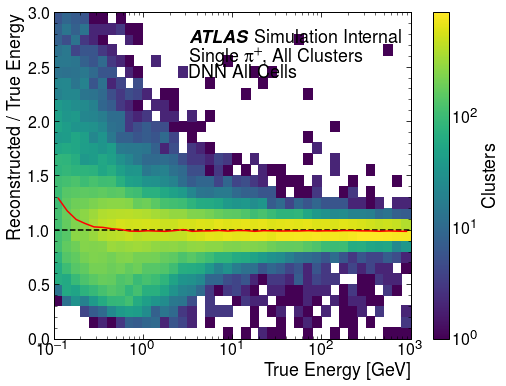

In [25]:
xcenter, medRegDNN = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_All_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_DNN_profile.pdf',
                 'median',
                 xlabel = 'True Energy [GeV]', ylabel = 'Reconstructed / True Energy',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'DNN All Cells'}])

<Figure size 576x432 with 0 Axes>

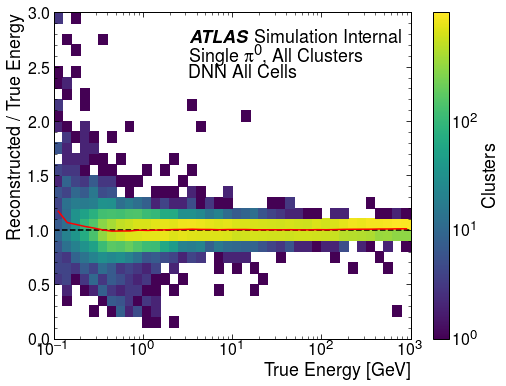

In [26]:
xcenter, medRegDNN_0 = ru.responsePlot(p0[p0.test].cluster_ENG_CALIB_TOT, p0[p0.test].predict_regressor_All_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_DNN_0_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlabel = 'True Energy [GeV]', ylabel = 'Reconstructed / True Energy',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{0}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'DNN All Cells'}])

<Figure size 576x432 with 0 Axes>

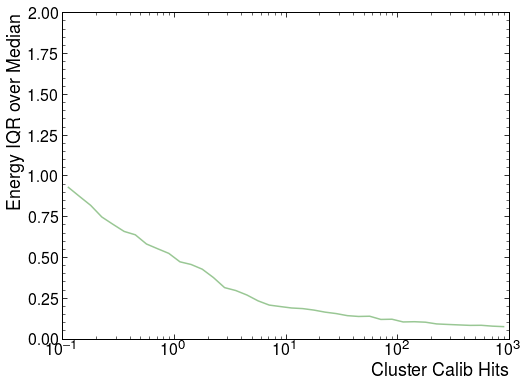

In [27]:
xcenter, iqrOverMedDNN = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].predict_regressor_All_EoverCalib, statistic='iqrOverMed')

<Figure size 576x432 with 0 Axes>

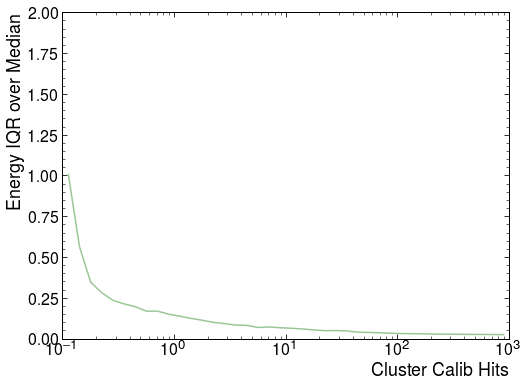

In [28]:
xcenter, iqrOverMedDNN_0 = ru.resolutionPlot(p0[p0.test].cluster_ENG_CALIB_TOT, 
                        p0[p0.test].predict_regressor_All_EoverCalib, statistic='iqrOverMed')

## Max CNN

In [29]:
def channels_EMB2G_EMB1F_model_all2():
    with strategy.scope():

        #here come the eta and energy
        input0 = Input(shape=(2), name='input0')
        x0 = Dense(12, activation='relu',kernel_initializer='normal')(input0)
        x0 = Dense(6, activation='relu')(x0)
        x0 = Dense(4, activation='relu')(x0)

        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input1)
        # x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(64, activation='relu')(x1)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim), name='input2')
        x2 = Dense(emb1_dim, activation='relu')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 8, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x0, x1, x2]) 
        x = Dense(50, activation='relu')(x)    

        # final output
        output = Dense(1, kernel_initializer = 'normal', activation='linear')(x)

        model = Model(inputs = [input0, input1,input2], outputs = [output])
    
        opt = Adam(lr=5e-6)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])  
        return model

In [30]:
regressor_CNN = KerasRegressor(build_fn=channels_EMB2G_EMB1F_model_all2, batch_size=200*ngpu, epochs=250, verbose=2)
print(channels_EMB2G_EMB1F_model_all2().summary())

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          262656      input2[0][0]                     
__________________________________________________________________________________________________
input1 (InputLayer)             [(None, 6, 16, 16)]  0                                            
____________

In [31]:
pp_features = np.column_stack((pp['s_logE'],pp['s_eta']))
p0_features = np.column_stack((p0['s_logE'],p0['s_eta']))

In [28]:
history_cnn = regressor_CNN.fit([ pp_features[pp.train], ppcells_EMB2G_channels[pp.train], ppcells_EMB1_flat[pp.train] ],
                                              pp[pp.train].s_logECalib.to_numpy(),
                                              validation_data = ([ pp_features[pp.val], ppcells_EMB2G_channels[pp.val], ppcells_EMB1_flat[pp.val] ], pp[pp.val].s_logECalib.to_numpy()))

.0172 - mae: 0.0792 - mse: 0.0172 - val_loss: 0.0169 - val_mae: 0.0801 - val_mse: 0.0169
Epoch 99/250
305176/305176 - 9s - loss: 0.0172 - mae: 0.0791 - mse: 0.0172 - val_loss: 0.0169 - val_mae: 0.0796 - val_mse: 0.0169
Epoch 100/250
305176/305176 - 9s - loss: 0.0172 - mae: 0.0790 - mse: 0.0172 - val_loss: 0.0167 - val_mae: 0.0783 - val_mse: 0.0167
Epoch 101/250
305176/305176 - 9s - loss: 0.0171 - mae: 0.0789 - mse: 0.0171 - val_loss: 0.0168 - val_mae: 0.0788 - val_mse: 0.0168
Epoch 102/250
305176/305176 - 9s - loss: 0.0171 - mae: 0.0789 - mse: 0.0171 - val_loss: 0.0170 - val_mae: 0.0800 - val_mse: 0.0170
Epoch 103/250
305176/305176 - 9s - loss: 0.0171 - mae: 0.0788 - mse: 0.0171 - val_loss: 0.0168 - val_mae: 0.0795 - val_mse: 0.0168
Epoch 104/250
305176/305176 - 9s - loss: 0.0170 - mae: 0.0786 - mse: 0.0170 - val_loss: 0.0165 - val_mae: 0.0768 - val_mse: 0.0165
Epoch 105/250
305176/305176 - 9s - loss: 0.0171 - mae: 0.0786 - mse: 0.0171 - val_loss: 0.0170 - val_mae: 0.0804 - val_mse: 0.

<Figure size 576x432 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


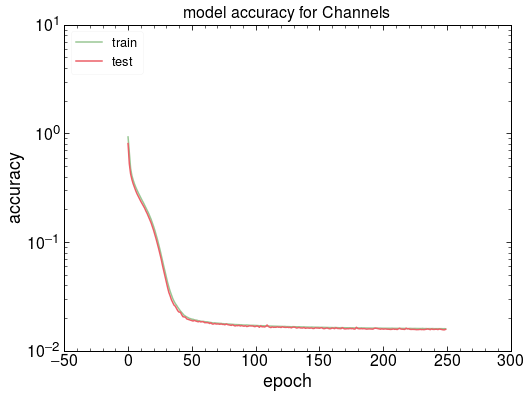

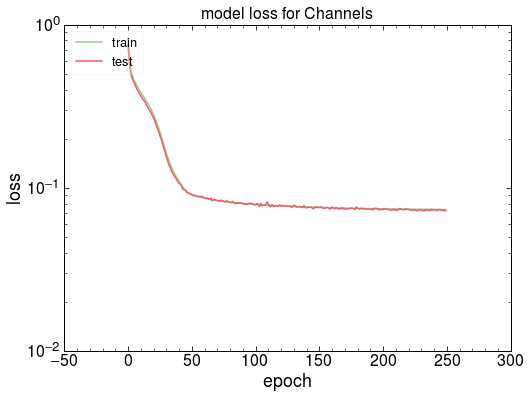

In [29]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_cnn.history['mse'])
    plt.plot(history_cnn.history['val_mse'])
    plt.title('model accuracy for Channels')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_cnn.history['mae'])
    plt.plot(history_cnn.history['val_mae'])
    plt.title('model loss for Channels')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [42]:
regressor_CNN.model = tf.keras.models.load_model(modelpath+"cnn_max_pp.h5")

In [43]:
pp['predict_regressor_cnn'] = np.exp(scaler_cal.inverse_transform(regressor_CNN.predict([ pp_features, ppcells_EMB2G_channels, ppcells_EMB1_flat])))
pp['predict_regressor_cnn_EoverCalib'] = pp.predict_regressor_cnn / pp.cluster_ENG_CALIB_TOT

435967/1 - 4s


In [44]:
regressor_0_CNN = KerasRegressor(build_fn=channels_EMB2G_EMB1F_model_all2, batch_size=200*ngpu, epochs=250, verbose=2)
print(channels_EMB2G_EMB1F_model_all2().summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 512)          262656      input2[0][0]                     
__________________________________________________________________________________________________
input1 (InputLayer)             [(None, 6, 16, 16)]  0                                            
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 512)          0           dense_35[0][0]                   
____________________________________________________________________________________________

In [45]:
regressor_0_CNN.model = tf.keras.models.load_model(modelpath+"cnn_max_p0.h5")

In [32]:
history_0_cnn = regressor_0_CNN.fit([ p0_features[p0.train], p0cells_EMB2G_channels[p0.train], p0cells_EMB1_flat[p0.train] ],
                                              p0[p0.train].s_logECalib.to_numpy(),
                                              validation_data = ([ p0_features[p0.val], p0cells_EMB2G_channels[p0.val], p0cells_EMB1_flat[p0.val] ], p0[p0.val].s_logECalib.to_numpy()))


.0026 - mae: 0.0289 - mse: 0.0026 - val_loss: 0.0038 - val_mae: 0.0465 - val_mse: 0.0038
Epoch 99/250
184723/184723 - 6s - loss: 0.0026 - mae: 0.0286 - mse: 0.0026 - val_loss: 0.0038 - val_mae: 0.0463 - val_mse: 0.0038
Epoch 100/250
184723/184723 - 5s - loss: 0.0025 - mae: 0.0282 - mse: 0.0025 - val_loss: 0.0037 - val_mae: 0.0453 - val_mse: 0.0037
Epoch 101/250
184723/184723 - 6s - loss: 0.0025 - mae: 0.0278 - mse: 0.0025 - val_loss: 0.0035 - val_mae: 0.0440 - val_mse: 0.0035
Epoch 102/250
184723/184723 - 6s - loss: 0.0025 - mae: 0.0275 - mse: 0.0025 - val_loss: 0.0036 - val_mae: 0.0445 - val_mse: 0.0036
Epoch 103/250
184723/184723 - 6s - loss: 0.0024 - mae: 0.0271 - mse: 0.0024 - val_loss: 0.0033 - val_mae: 0.0426 - val_mse: 0.0033
Epoch 104/250
184723/184723 - 6s - loss: 0.0024 - mae: 0.0268 - mse: 0.0024 - val_loss: 0.0033 - val_mae: 0.0417 - val_mse: 0.0033
Epoch 105/250
184723/184723 - 5s - loss: 0.0024 - mae: 0.0265 - mse: 0.0024 - val_loss: 0.0032 - val_mae: 0.0405 - val_mse: 0.

<Figure size 576x432 with 0 Axes>

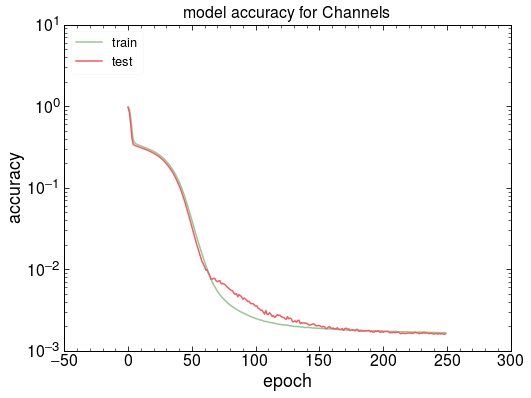

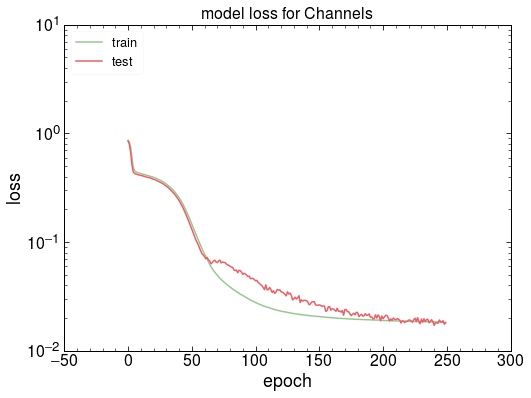

In [33]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_0_cnn.history['mse'])
    plt.plot(history_0_cnn.history['val_mse'])
    plt.title('model accuracy for Channels')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_0_cnn.history['mae'])
    plt.plot(history_0_cnn.history['val_mae'])
    plt.title('model loss for Channels')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [46]:
p0['predict_regressor_cnn'] = np.exp(scaler_0_cal.inverse_transform(regressor_0_CNN.predict([ p0_features, p0cells_EMB2G_channels, p0cells_EMB1_flat])))
p0['predict_regressor_cnn_EoverCalib'] = p0.predict_regressor_cnn / p0.cluster_ENG_CALIB_TOT

263891/1 - 3s


<Figure size 576x432 with 0 Axes>

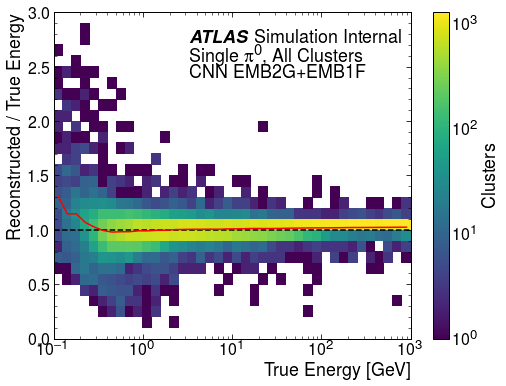

In [47]:
xcenter, medRegCNN_0 = ru.responsePlot(p0[p0.test].cluster_ENG_CALIB_TOT, p0[p0.test].predict_regressor_cnn_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_CNN_0_profile.pdf',
                 'median',
                 xlabel = 'True Energy [GeV]', ylabel = 'Reconstructed / True Energy',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{0}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'CNN EMB2G+EMB1F'}])

In [38]:
regressor_0_CNN.model.save(modelpath+"cnn_max_p0.h5")
regressor_CNN.model.save(modelpath+"cnn_max_pp.h5")

<Figure size 576x432 with 0 Axes>

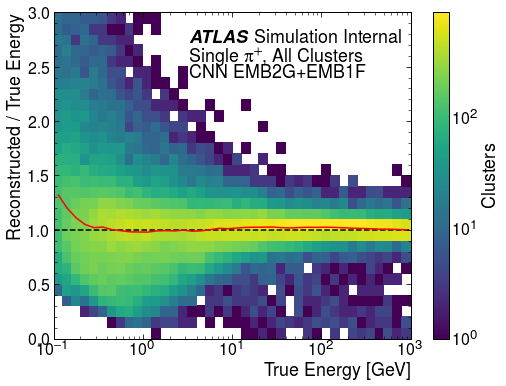

In [48]:
xcenter, medRegCNN = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_cnn_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_CNN_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlabel = 'True Energy [GeV]', ylabel = 'Reconstructed / True Energy',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'CNN EMB2G+EMB1F'}])

<Figure size 576x432 with 0 Axes>

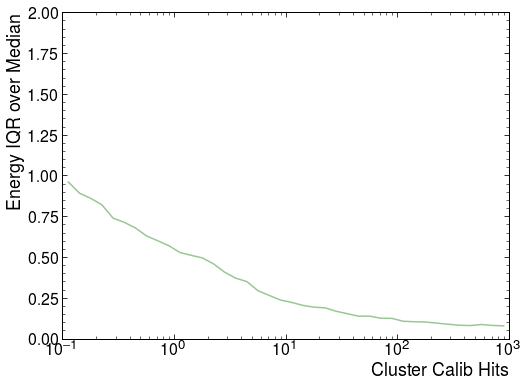

In [49]:
xcenter, iqrOverMedCNN = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].predict_regressor_cnn_EoverCalib, statistic='iqrOverMed')

<Figure size 576x432 with 0 Axes>

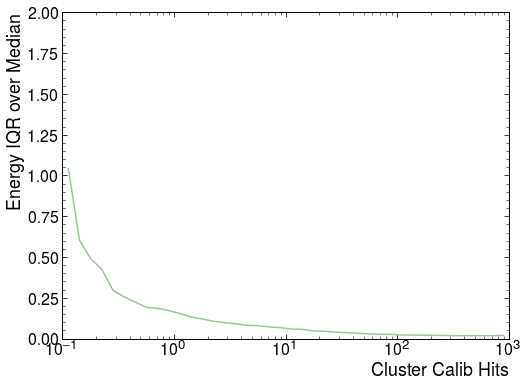

In [50]:
xcenter, iqrOverMedCNN_0 = ru.resolutionPlot(p0[p0.test].cluster_ENG_CALIB_TOT, 
                        p0[p0.test].predict_regressor_cnn_EoverCalib, statistic='iqrOverMed')

## Load up Piyush DenseNet results

In [51]:
pp_dense = np.load(path_prefix + "regression/20200609_piplus_log_mae_dense_allClust/training_data_piplus_log_mae.npz")

In [52]:
for blah in pp_dense:
    print(blah)

calib_pred
calib
calib_fold


<Figure size 576x432 with 0 Axes>

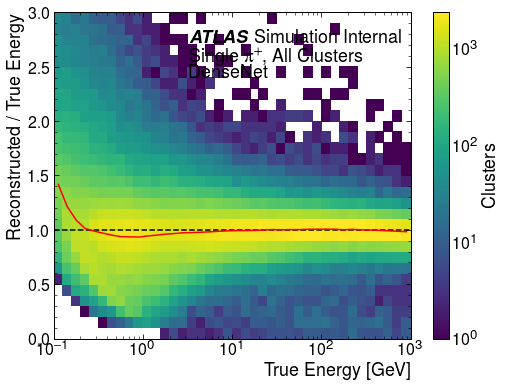

In [53]:
xcenter, medRegDense = ru.responsePlot(pp_dense['calib'], pp_dense['calib_pred'] / pp_dense['calib'],
                 plotpath+'hist_2D_calib_vs_ratioReg_Dense_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlabel = 'True Energy [GeV]', ylabel = 'Reconstructed / True Energy',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'DenseNet'}])

<Figure size 576x432 with 0 Axes>

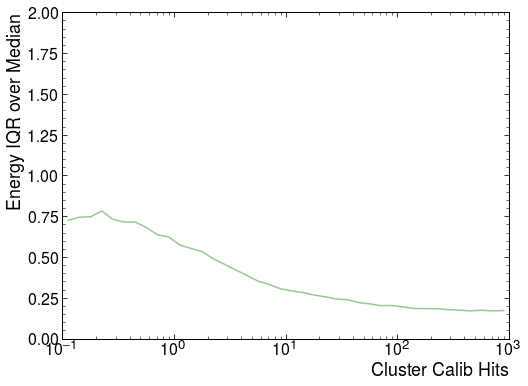

In [54]:
xcenter, iqrOverMedDense = ru.resolutionPlot(pp_dense['calib'], 
                        pp_dense['calib_pred'] / pp_dense['calib'], statistic='iqrOverMed')

In [55]:
p0_dense = np.load(path_prefix + "regression/20200609_pi0_log_mae_dense_allClust/training_data_pi0_log_mae.npz")

<Figure size 576x432 with 0 Axes>

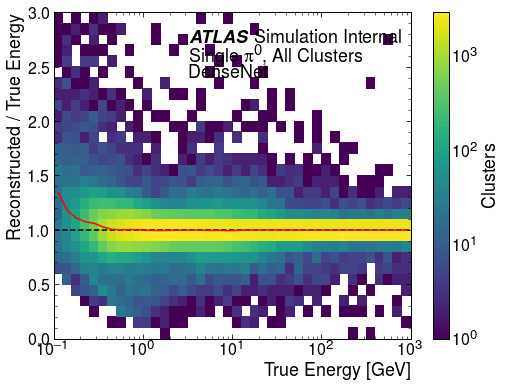

In [56]:
xcenter, medRegDense_0 = ru.responsePlot(p0_dense['calib'], p0_dense['calib_pred'] / p0_dense['calib'],
                 plotpath+'hist_2D_calib_vs_ratioReg_Dense_0_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlabel = 'True Energy [GeV]', ylabel = 'Reconstructed / True Energy',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{0}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'DenseNet'}])

<Figure size 576x432 with 0 Axes>

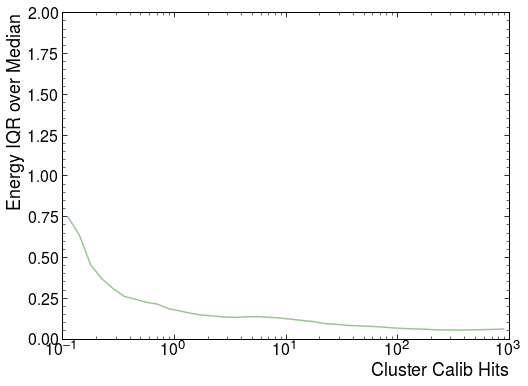

In [57]:
xcenter, iqrOverMedDense_0 = ru.resolutionPlot(p0_dense['calib'], 
                        p0_dense['calib_pred'] / p0_dense['calib'], statistic='iqrOverMed')

## EM Scale

<Figure size 576x432 with 0 Axes>

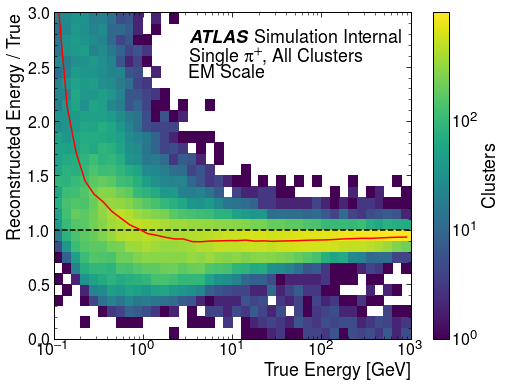

In [58]:
xcenter, medRegEM = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].clusterEoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_em_profile.pdf',
                 'median',
                 xlabel = 'True Energy [GeV]', ylabel = 'Reconstructed Energy / True',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'EM Scale'}])

<Figure size 576x432 with 0 Axes>

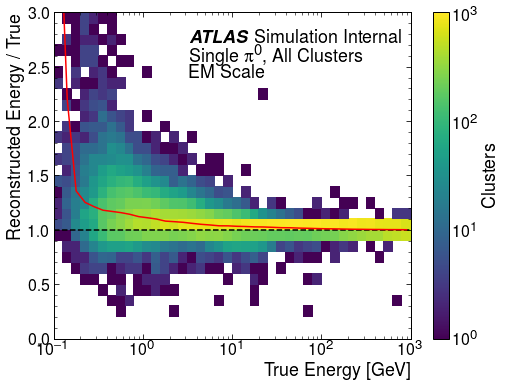

In [59]:
xcenter, medRegEM_0 = ru.responsePlot(p0[p0.test].cluster_ENG_CALIB_TOT, p0[p0.test].clusterEoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_em_0_profile.pdf',
                 'median',
                 xlabel = 'True Energy [GeV]', ylabel = 'Reconstructed Energy / True',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{0}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'EM Scale'}])

<Figure size 576x432 with 0 Axes>

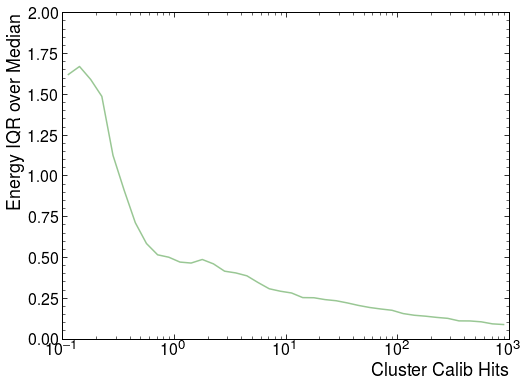

In [60]:
xcenter, iqrOverMedEM = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].clusterEoverCalib, statistic='iqrOverMed')

<Figure size 576x432 with 0 Axes>

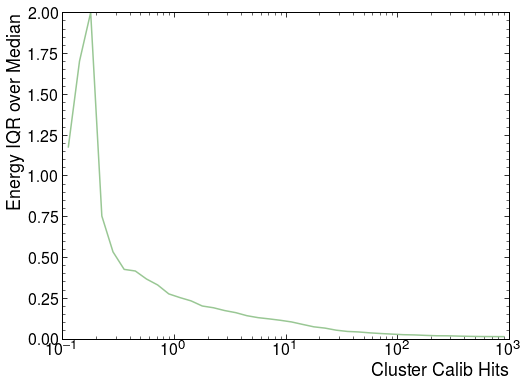

In [61]:
xcenter, iqrOverMedEM_0 = ru.resolutionPlot(p0[p0.test].cluster_ENG_CALIB_TOT, 
                        p0[p0.test].clusterEoverCalib, statistic='iqrOverMed')

## LC

In [62]:
pp['clusterHadE'] = pp.clusterE * pp.cluster_HAD_WEIGHT
pp['clusterHadEoverCalib'] = pp.clusterHadE / pp.cluster_ENG_CALIB_TOT
p0['clusterHadE'] = p0.clusterE * p0.cluster_HAD_WEIGHT
p0['clusterHadEoverCalib'] = p0.clusterHadE / p0.cluster_ENG_CALIB_TOT

<Figure size 576x432 with 0 Axes>

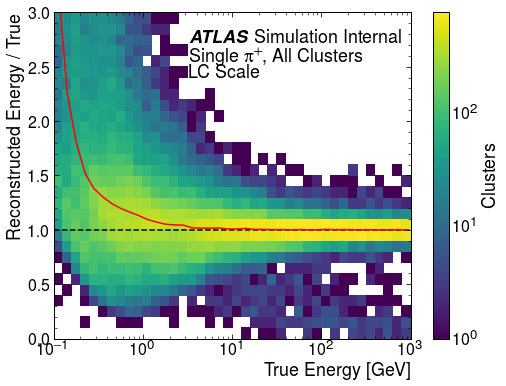

In [63]:
xcenter, medBaseLC = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].clusterHadEoverCalib,
                        plotpath+'hist_2D_calib_vs_lc_pp_profile.pdf','median',
                        xlabel = 'True Energy [GeV]', ylabel = 'Reconstructed Energy / True',
                        atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'LC Scale'}])

<Figure size 576x432 with 0 Axes>

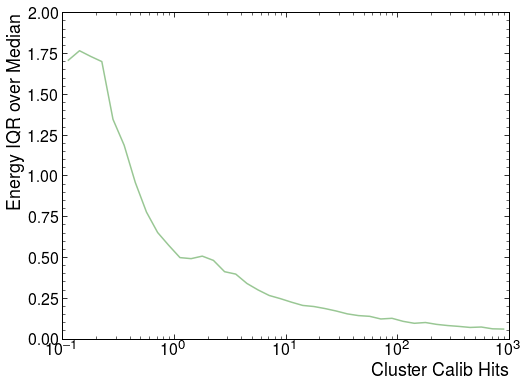

In [64]:
xcenter, iqrOverMedLC = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].clusterHadEoverCalib, statistic='iqrOverMed')

<Figure size 576x432 with 0 Axes>

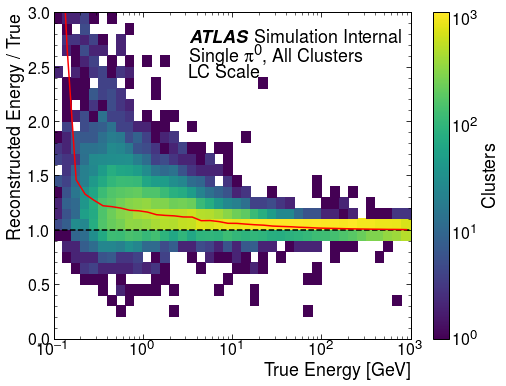

In [65]:
xcenter, medRegLC_0 = ru.responsePlot(p0[p0.test].cluster_ENG_CALIB_TOT, p0[p0.test].clusterHadEoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_had_0_profile.pdf',
                 'median',
                 xlabel = 'True Energy [GeV]', ylabel = 'Reconstructed Energy / True',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{0}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'LC Scale'}])

<Figure size 576x432 with 0 Axes>

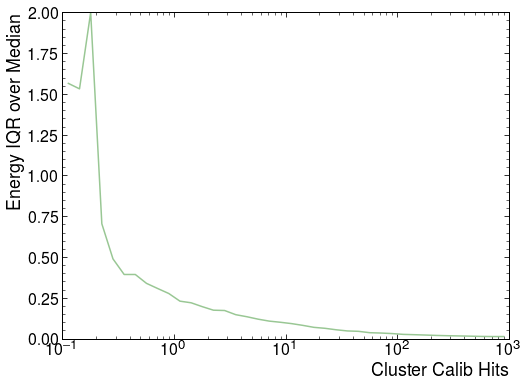

In [66]:
xcenter, iqrOverMedLC_0 = ru.resolutionPlot(p0[p0.test].cluster_ENG_CALIB_TOT, 
                        p0[p0.test].clusterHadEoverCalib, statistic='iqrOverMed')

## Max's DenseNet

In [5]:
def stretched_tanh(x):
    beta = 5
    return beta*K.tanh(x)

def norm(x, xmax, xmin):
    xmin = xmin - np.finfo(np.float32).eps
    return (x-xmin)/(xmax-xmin)

def denorm(x, xmax, xmin):
    xmin = xmin - np.finfo(np.float32).eps
    return x*(xmax-xmin) + xmin


In [6]:
pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False, energyScale = 'clusterE', energyFrame = pdata[ifile])
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

In [7]:
mu.addCleaning(pdata['piplus'], pcells['piplus'])

In [8]:
ppdata = pdata['piplus'][pdata['piplus'].cleanEmpty]
ppcells = mu.filterCells(pcells['piplus'], pdata['piplus'])

In [9]:
pcellsE23_EMB2G_channels = mu.setupChannelImages(mu.rebinImages(ppcells, (16, 16), layers=['EMB2', 'EMB3']),last=True)
pcellsE1_EMB1G_channels = mu.setupChannelImages(mu.rebinImages(ppcells, (128, 4), layers=['EMB1']),last=True)
pcellsT123_T1G_channels = mu.setupChannelImages(mu.rebinImages(ppcells, (4, 4), layers=['TileBar0', 'TileBar1', 'TileBar2']),last=True)

In [10]:
ppdata['logECalib'] = np.log10(ppdata.cluster_ENG_CALIB_TOT)
calib_max = np.amax(ppdata.logECalib)
calib_min = np.amin(ppdata.logECalib)
ppdata['s_logECalib'] = norm(ppdata.logECalib, xmax = calib_max, xmin = calib_min)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [11]:
tf.keras.utils.get_custom_objects().update({'stretched_tanh': Activation(stretched_tanh)})

In [12]:
from tensorflow.keras import backend as K
model_dense_02 = tf.keras.models.load_model(modelpath + 'dense_fold0_best.h5')

In [13]:
ppdata['predict_dense_d02_test'] = 10.**(denorm(model_dense_02.predict([pcellsE1_EMB1G_channels, pcellsE23_EMB2G_channels, pcellsT123_T1G_channels]), xmax = calib_max, xmin = calib_min))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
ppdata['predict_dense_d02_test_EoverCalib'] = ppdata.predict_dense_d02_test / ppdata.cluster_ENG_CALIB_TOT

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<Figure size 576x432 with 0 Axes>

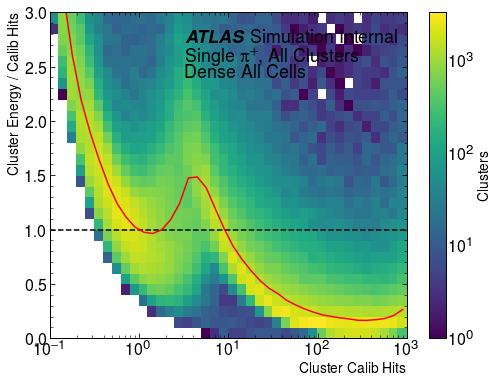

In [15]:
xcenter, medReg_p1_d02 = ru.responsePlot(ppdata.cluster_ENG_CALIB_TOT, ppdata.predict_dense_d02_test_EoverCalib,
                #  plotpath+'hist_2D_calib_vs_ratioReg_p1_d02_kfold5_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'Dense All Cells'}])

## Comparison Plots

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 576x432 with 0 Axes>

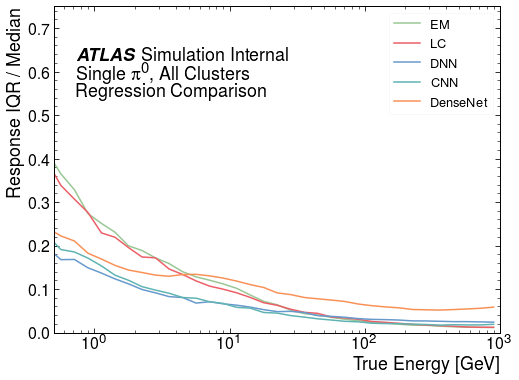

In [67]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrOverMedEM_0, iqrOverMedLC_0, iqrOverMedDNN_0, iqrOverMedCNN_0, iqrOverMedDense_0],
                labels = ['EM', 'LC', 'DNN', 'CNN', 'DenseNet'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR / Median',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_EM_LC_DNN_CNN_0.pdf",
                x_min = 0.5, x_max = 1000., y_max = 0.75,
                linestyles = ['solid', 'solid','solid','solid', 'solid'],
                atlas_x = 0.05, atlas_y = 0.875, simulation = True,
                textlist = [{'x': 0.05, 'y': 0.775, 'text': 'Single $\pi^{0}$, All Clusters'},
                            {'x': 0.05, 'y': 0.725,  'text': 'Regression Comparison'}])

<Figure size 576x432 with 0 Axes>

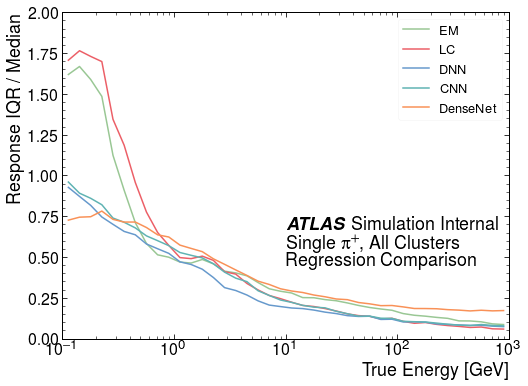

In [68]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrOverMedEM, iqrOverMedLC, iqrOverMedDNN, iqrOverMedCNN, iqrOverMedDense],
                labels = ['EM', 'LC', 'DNN', 'CNN', 'DenseNet'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR / Median',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_EM_LC_DNN_CNN.pdf",
                y_max = 2.,
                linestyles = ['solid', 'solid','solid', 'solid', 'solid'],
                atlas_x = 0.5, atlas_y = 0.375, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.275, 'text': 'Single $\pi^{+}$, All Clusters'},
                            {'x': 0.5, 'y': 0.225,  'text': 'Regression Comparison'}])

<Figure size 576x432 with 0 Axes>

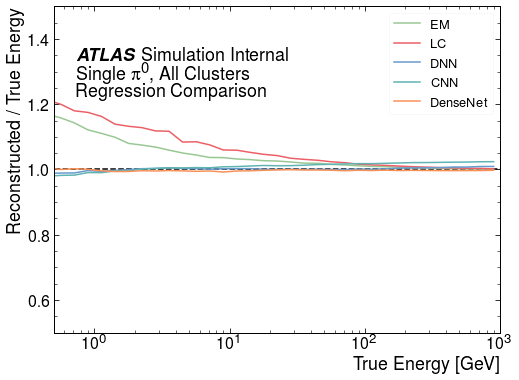

In [69]:
pu.lineOverlay(xcenter=xcenter, lines = [medRegEM_0, medRegLC_0, medRegDNN_0, medRegCNN_0, medRegDense_0],
                labels = ['EM', 'LC', 'DNN', 'CNN', 'DenseNet'],
                xlabel = 'True Energy [GeV]', ylabel = 'Reconstructed / True Energy',
                figfile = plotpath + "hist_2D_calib_vs_response_Overlay_EM_LC_DNN_CNN_0.pdf",
                x_min = 0.5, x_max = 1000.,y_min = 0.5, y_max = 1.5,
                linestyles = ['solid', 'solid','solid','solid', 'solid'],
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.05, atlas_y = 0.875, simulation = True,
                textlist = [{'x': 0.05, 'y': 0.775, 'text': 'Single $\pi^{0}$, All Clusters'},
                            {'x': 0.05, 'y': 0.725,  'text': 'Regression Comparison'}])

<Figure size 576x432 with 0 Axes>

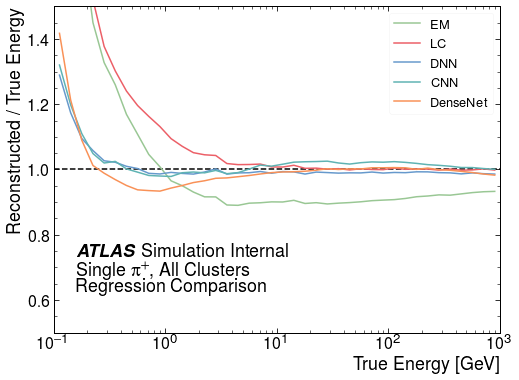

In [70]:
pu.lineOverlay(xcenter=xcenter, lines = [medRegEM, medBaseLC, medRegDNN, medRegCNN, medRegDense],
                labels = ['EM', 'LC', 'DNN', 'CNN', 'DenseNet'],
                xlabel = 'True Energy [GeV]', ylabel = 'Reconstructed / True Energy',
                figfile = plotpath + "hist_2D_calib_vs_response_Overlay_EM_LC_DNN_CNN.pdf",
                x_max = 1000., y_min = 0.5, y_max = 1.5,
                linestyles = ['solid', 'solid','solid','solid', 'solid'],
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.05, atlas_y = 0.275, simulation = True,
                textlist = [{'x': 0.05, 'y': 0.175, 'text': 'Single $\pi^{+}$, All Clusters'},
                            {'x': 0.05, 'y': 0.125,  'text': 'Regression Comparison'}])

In [88]:
print('test')

test
